In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from konlpy.tag import Okt; t = Okt()
import numpy as np
from collections import Counter
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer; tokenizer = Tokenizer()
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import re

import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
# 데이터 불러오기
review_data = pd.read_csv('./review_data.csv')
review_data.head()

,name,score,review
0,로지,100,모둠 사시미에 줄서 봅니다.
1,로지,100,너무 숙성된(?) 사시미...친절하지만 맛은 그다지.
2,재패니즈다이닝안심,80,맛있습니다 잘먹었습니다\n또 갈거 같은데 뭔가 모르게\n와~~하기에는 좀\n아쉬움이...
3,재패니즈다이닝안심,80,역대급 맛집이에요
4,재패니즈다이닝안심,80,사시미랑 구이랑 모두 다 너무 훌륭합니다 !


In [3]:
# 결측값 확인
review_data.isna().sum()

name      0
score     0
review    0
dtype: int64

In [4]:
# 80점 이상이 긍정이란 가정하에 긍, 부정 라벨링
review_data['label'] = [1 if i>60 else 0 for i in review_data['score']]
review_data

,name,score,review,label
0,로지,100,모둠 사시미에 줄서 봅니다.,1
1,로지,100,너무 숙성된(?) 사시미...친절하지만 맛은 그다지.,1
2,재패니즈다이닝안심,80,맛있습니다 잘먹었습니다\n또 갈거 같은데 뭔가 모르게\n와~~하기에는 좀\n아쉬움이...,1
3,재패니즈다이닝안심,80,역대급 맛집이에요,1
4,재패니즈다이닝안심,80,사시미랑 구이랑 모두 다 너무 훌륭합니다 !,1
...,...,...,...,...
1042,카츠하나,100,잘함,1
1043,스시아오마츠,100,최근에 먹은곳중 가장 가격이상의 가치를 만드는곳,1
1044,스시아오마츠,100,근래에 방문한 곳 중에 가장 만족스러워요 😋,1
1045,스시아오마츠,100,샤리가 고슬고슬해서 맛있었어요\n디너였는데 양이 많아서 거의 2-3시간 먹은 것 같...,1


<Axes: >

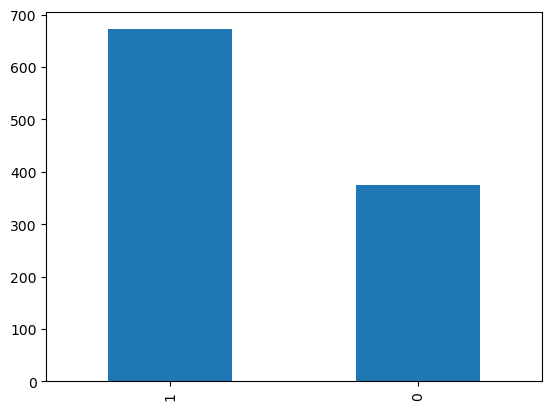

In [5]:
# 긍, 부정 분포
review_data['label'].value_counts().plot(kind='bar')

In [6]:
# 한글만 남기기
review_data['review'] = review_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]","")

# 불용어 리스트
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

# 토큰화 후 불용어 제거
review_data['tokenized'] = review_data['review'].apply(t.morphs)
review_data['tokenized'] = review_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

review_data.head()

,name,score,review,label,tokenized
0,로지,100,모둠사시미에줄서봅니다,1,"[모, 둠, 사시미, 줄, 서, 봅니다]"
1,로지,100,너무숙성된사시미친절하지만맛은그다지,1,"[너, 무숙, 성, 된, 사시미, 친절하지만, 맛, 그다지]"
2,재패니즈다이닝안심,80,맛있습니다잘먹었습니다또갈거같은데뭔가모르게와하기에는좀아쉬움이있어서별개네요,1,"[맛있습니다, 잘, 먹었습니다, 또, 갈거, 같은데, 뭔가, 모르게, 와하기에, 좀..."
3,재패니즈다이닝안심,80,역대급맛집이에요,1,"[역대, 급, 맛집, 이에요]"
4,재패니즈다이닝안심,80,사시미랑구이랑모두다너무훌륭합니다,1,"[사시미, 랑, 구이, 랑, 모두, 너무, 훌륭합니다]"


In [7]:
# 긍정과 부정에 따른 단어의 빈도수
positive_words = np.hstack(review_data[review_data.label==1]['tokenized'].values)
negative_words = np.hstack(review_data[review_data.label==0]['tokenized'].values)

In [8]:
# 부정 리뷰에 많이 나온 토큰
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('맛', 97), ('더', 96), ('너무', 80), ('보기', 78), ('하고', 69), ('곳', 57), ('음식', 55), ('으로', 52), ('님', 50), ('사장', 49), ('가격', 48), ('로', 47), ('에서', 46), ('분', 45), ('만', 43), ('요', 39), ('니', 37), ('식사', 35), ('때', 34), ('서', 33)]


In [9]:
# 긍정 리뷰에 많이 나온 토큰
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('맛', 160), ('너무', 137), ('더', 90), ('보기', 77), ('님', 74), ('곳', 74), ('맛있어요', 68), ('음식', 66), ('으로', 65), ('가격', 65), ('스시', 62), ('입니다', 60), ('로', 59), ('요', 52), ('나', 51), ('좋아요', 49), ('적', 48), ('에서', 47), ('정말', 45), ('진짜', 45)]


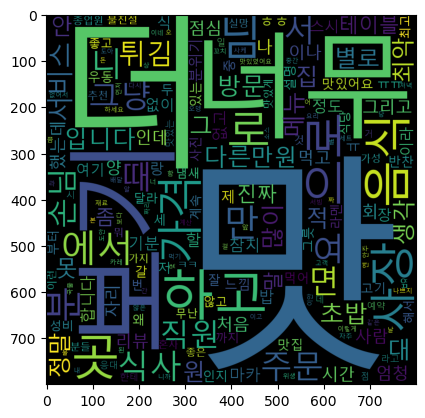

In [10]:
# 부정 워드클라우드
wc = WordCloud(
    font_path='C:/Windows/Fonts/malgun.ttf', width=400, 
    height=400, scale=2.0, max_font_size=250
)
gen = wc.generate_from_frequencies(negative_word_count)
plt.figure()
plt.imshow(gen)

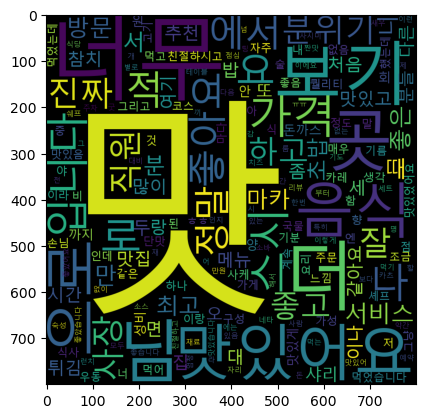

In [11]:
# 긍정 워드클라우드
gen = wc.generate_from_frequencies(positive_word_count)
plt.figure()
plt.imshow(gen)

긍정 리뷰의 평균 길이 : 19.30654761904762
부정 리뷰의 평균 길이 : 27.186666666666667


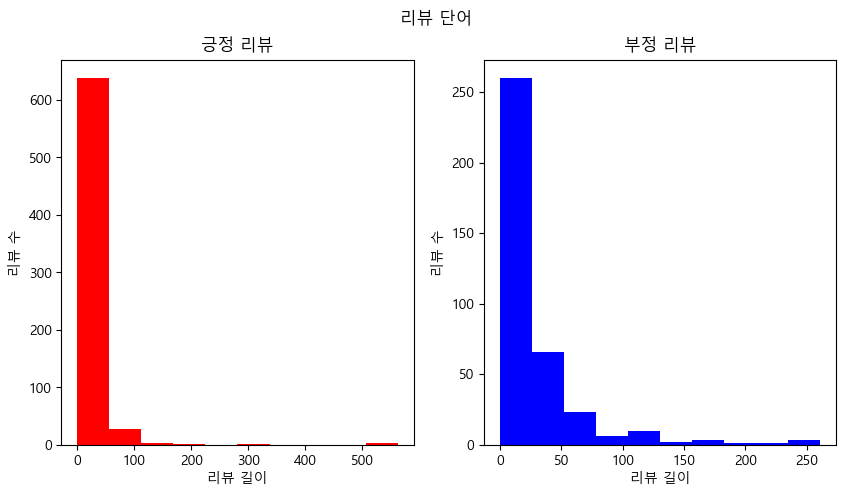

In [12]:
# 그래프 한글 깨짐
plt.rc('font', family='Malgun Gothic')

# 긍정과 부정에 따른 길이 분포
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
text_len = review_data[review_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('긍정 리뷰')
ax1.set_xlabel('리뷰 길이')
ax1.set_ylabel('리뷰 수')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = review_data[review_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('부정 리뷰')
fig.suptitle('리뷰 단어')
ax2.set_xlabel('리뷰 길이')
ax2.set_ylabel('리뷰 수')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [13]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    review_data['tokenized'], review_data['label'], test_size=0.15, random_state=3
)

In [14]:
tokenizer.fit_on_texts(X_train)
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수 총 합

# 단어와 빈도수를 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어 등장 빈도수가 threshold보다 작으면
    if value<threshold:
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합의 크기 :',total_cnt)
print('등장 빈도 %s번 이하인 희귀 단어 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합의 희귀 단어 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도의 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합의 크기 : 6612
등장 빈도 1번 이하인 희귀 단어 수: 4352
단어 집합의 희귀 단어 비율: 65.81972171808832
전체 등장 빈도의 희귀 단어 등장 빈도 비율: 21.932167514992692


In [15]:
# vocab_size = 단어 집합+(패딩 토큰+OOV 토큰)
vocab_size = total_cnt-rare_cnt+2
vocab_size

2262

In [16]:
# 시퀀스 형태로 변환
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [17]:
print(X_train[:3])

[[196, 230, 1, 15, 1429, 1, 799], [1, 180, 634, 79, 197, 635, 54, 280], [131, 20, 1021, 525, 2, 526, 141, 55, 142, 7, 450, 1430, 58, 42, 109, 1, 12, 1, 636, 1431, 73, 346, 86, 527, 6, 13]]


In [18]:
print(tokenizer.sequences_to_texts(X_train[:3]))

['친절 데 OOV 에서 철수 OOV 나왔어요', 'OOV 입 코 까지 모든 만족스러운 시간 이었습니다', '하나 나 정성 느껴지는 맛 플레이 팅 그리고 셰프 님 께 서술 이나 메뉴 추천 OOV 하고 OOV 해주셔서 늘 기분 좋게 먹고 나오는 곳 입니다']


In [19]:
print(X_test[:3])

[[1, 213, 1, 167, 128, 1, 1926, 1, 672, 1, 383, 662, 20, 47, 1, 104, 784, 108, 62, 64, 12, 1, 555, 408, 39, 1, 49, 1, 1, 1, 288, 383, 590, 95, 8, 1, 1926, 47, 383, 87, 37, 781, 601, 15, 721, 233, 58, 1], [61, 33, 38, 646, 95, 121, 56], [747, 216, 1, 1, 1]]


In [20]:
print(tokenizer.sequences_to_texts(X_test[:3]))

['OOV 여 OOV 장 가게 OOV 한국말 OOV 대로 OOV 응대 제대로 나 손님 OOV 자리 안내 할 생각 안 하고 OOV 그래서 아무 대 OOV 그냥 OOV OOV OOV 무슨 응대 그런 식 으로 OOV 한국말 손님 응대 못 면 걍 주방 에서 밑 간 이나 OOV', '맛있고 분위기 좋아요 일본 식 카레 맛집', '일단 한번 OOV OOV OOV']


리뷰의 최대 길이 : 562
리뷰의 평균 길이 : 22.32058492688414


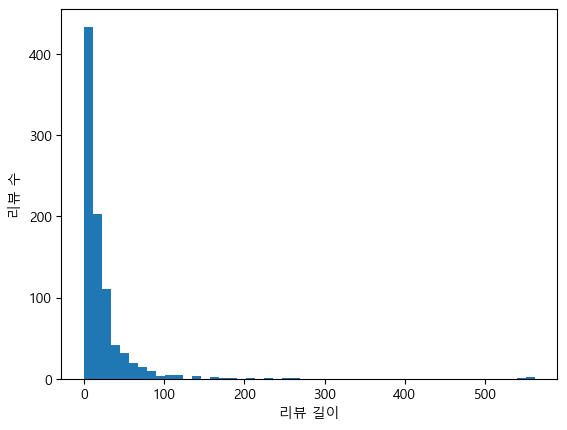

In [21]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('리뷰 길이')
plt.ylabel('리뷰 수')
plt.show()

In [22]:
max_len = sum(map(len, X_train))//len(X_train)
count = len([sentence for sentence in X_train if len(sentence)<=max_len])
print('전체 샘플 중 길이 %s 이하인 샘플 비율: %s'%(max_len, (count/len(X_train)*100)))

전체 샘플 중 길이 22 이하인 샘플 비율: 71.65354330708661


In [23]:
# max_len을 기준으로 패딩
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [24]:
embedding_dim = 256
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

# 과적합 방지
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint(
    'best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True
)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(
    X_train, y_train, epochs=20, callbacks=[es, mc], batch_size=64, validation_split=0.2
)

Epoch 1/20
 9/12 [=====================>........] - ETA: 0s - loss: 0.6617 - acc: 0.6215
Epoch 1: val_acc improved from -inf to 0.63483, saving model to best_model.h5
12/12 [==============================] - 3s 83ms/step - loss: 0.6489 - acc: 0.6385 - val_loss: 0.6401 - val_acc: 0.6348
Epoch 2/20
 9/12 [=====================>........] - ETA: 0s - loss: 0.6027 - acc: 0.6667
Epoch 2: val_acc improved from 0.63483 to 0.64045, saving model to best_model.h5
12/12 [==============================] - 0s 21ms/step - loss: 0.5961 - acc: 0.6807 - val_loss: 0.6530 - val_acc: 0.6404
Epoch 3/20
 9/12 [=====================>........] - ETA: 0s - loss: 0.4986 - acc: 0.7726
Epoch 3: val_acc improved from 0.64045 to 0.67978, saving model to best_model.h5
12/12 [==============================] - 0s 21ms/step - loss: 0.4956 - acc: 0.7764 - val_loss: 0.6258 - val_acc: 0.6798
Epoch 4/20
 9/12 [=====================>........] - ETA: 0s - loss: 0.3434 - acc: 0.8715
Epoch 4: val_acc improved from 0.67978 to 0.

In [25]:
# 모델 요약
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 256)         579072    
                                                                 
 gru (GRU)                   (None, 128)               148224    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 727,425
Trainable params: 727,425
Non-trainable params: 0
_________________________________________________________________


In [26]:
# 모델 테스트
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

5/5 [==============================] - 1s 57ms/step - loss: 0.9581 - acc: 0.5696

 테스트 정확도: 0.5696


In [27]:
def sentiment_predict(new_sentence):
    # 한글만 남기기
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    # 형태소 분리
    new_sentence = t.morphs(new_sentence)
    # 불용어 제거
    new_sentence = [word for word in new_sentence if not word in stopwords]
    # 시퀀스 변환
    encoded = tokenizer.texts_to_sequences([new_sentence])
    # 패딩
    pad_new = pad_sequences(encoded, maxlen=max_len)
    # 예측
    score = float(loaded_model.predict(pad_new))
    if(score>0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score*100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score)*100))

In [28]:
sentiment_predict('너무 맛있어서 토했어요')

1/1 [==============================] - 0s 316ms/step
92.76% 확률로 긍정 리뷰입니다.


In [29]:
sentiment_predict('너무 맛있어서 쓰레기통에 잘 넣어 놨어요')

1/1 [==============================] - 0s 17ms/step
96.82% 확률로 긍정 리뷰입니다.


In [30]:
sentiment_predict('감자는 고구마의 친구입니다.')

1/1 [==============================] - 0s 22ms/step
94.93% 확률로 긍정 리뷰입니다.


In [31]:
sentiment_predict('감자 감자 왕감자 정말 정말 좋아요 못 다 먹겠죠')

1/1 [==============================] - 0s 20ms/step
79.18% 확률로 긍정 리뷰입니다.


In [32]:
sentiment_predict('존맛탱')

1/1 [==============================] - 0s 20ms/step
94.77% 확률로 긍정 리뷰입니다.


In [33]:
sentiment_predict('맛없다')

1/1 [==============================] - 0s 21ms/step
90.82% 확률로 긍정 리뷰입니다.
